In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import plotly.express as px
import geopandas
import datetime
import warnings

warnings.filterwarnings('ignore')
plt.style.use('ggplot')

In [2]:
df=pd.read_csv(r"C:\Users\berid\python\csv_files\Supercharge Locations.csv",encoding= 'unicode_escape')

In [3]:
%%time
world=geopandas.read_file(geopandas.datasets.get_path('naturalearth_lowres'))
usa=geopandas.read_file(r"C:\Users\berid\python\geopandas\USA states\s_22mr22.shp")
china=geopandas.read_file(r"C:\Users\berid\python\geopandas\China provinces\chn_admbndl_ALL_ocha_2020.shp")

CPU times: total: 6.59 s
Wall time: 8.38 s


In [4]:
df

,Supercharger,Street Address,City,State,Zip,Country,Stalls,kW,GPS,Elev(m),Open Date,Unnamed: 11
0,"Buellton, CA",555 McMurray Rd,Buellton,CA,93427,USA,10,150.0,"34.61456, -120.188387",114,7/13/2013,NaN
1,"Corning, CA",950 Hwy 99,Corning,CA,96021,USA,6,150.0,"39.926454, -122.198393",87,10/18/2013,NaN
2,"Barstow, CA",2812 Lenwood Rd,Barstow,CA,92311,USA,16,150.0,"34.849129, -117.085446",725,11/19/2012,NaN
3,"Tifton, GA",1310 U.S. 82,Tifton,GA,31794,USA,8,150.0,"31.448847, -83.53221",92,7/10/2014,NaN
4,"Roseville, CA",1151 Galleria Blvd,Roseville,CA,95678,USA,7,150.0,"38.771208, -121.266149",66,4/29/2014,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...
5871,"Beijing - Haidian B+W Checker, China","69-1 Banjing Rd, Haidian District",Beijing,Beijing,NaN,China,2,120.0,"39.951088, 116.281837",58,NaN,NaN
5872,"Cagnes-sur-Mer  Polygone Riviera P2, France",27-9 Rue de la Grange Rimade,Cagnes-sur-Mer,Provence-Alpes-Côte d'Azur,6800,France,4,125.0,"43.666884, 7.124728",30,NaN,NaN
5873,"Naarden, Netherlands",IJsselmeerweg 3,Naarden,North Holland,1411 AA,Netherlands,32,150.0,"52.30858, 5.141127",2,NaN,NaN
5874,"Karlskrona, Sweden",Landbron 1 (private initiative but free for al...,Karlskrona,Blekinge,371 33,Sweden,2,60.0,"56.165403, 15.585989",4,NaN,NaN


In [5]:
df=df.drop(columns='Unnamed: 11')

In [6]:
df.isna().mean()[df.isna().mean().values>0]*100

State         2.076242
Zip          32.828455
kW            0.102110
Open Date    12.763785
dtype: float64

In [7]:
df['Lat']=df['GPS'].apply(lambda x:x.split(', ')[0].strip()).astype(float)
df['Long']=df['GPS'].apply(lambda x:x.split(', ')[-1].strip()).astype(float)

In [8]:
cities_grouped=df.groupby('City').agg({'Long':'mean','Lat':'mean'})
cities_grouped.columns=['City Long','City Lat']
df=df.merge(cities_grouped,on='City',how='left')

In [9]:
df.sample()

,Supercharger,Street Address,City,State,Zip,Country,Stalls,kW,GPS,Elev(m),Open Date,Lat,Long,City Long,City Lat
2849,"Houston - Hempstead Rd (SC), TX",19820 Hempstead Road,Houston,TX,77065,USA,16,250.0,"29.912978, -95.615944",39,6/29/2022,29.912978,-95.615944,-95.48112,29.799219


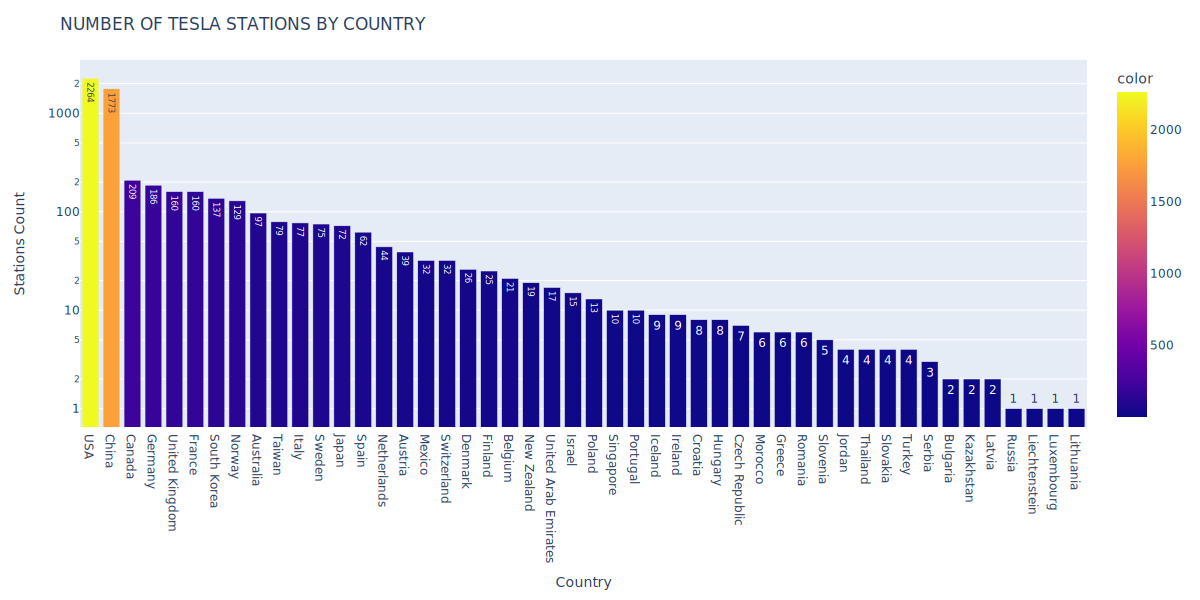

In [10]:
g=df['Country'].value_counts().sort_values(ascending=False)

fig=px.bar(x=g.index,y=g.values,text=g.values,color=g.values,log_y=True)
fig.update_layout(title=dict(text='NUMBER OF TESLA STATIONS BY COUNTRY',font_family='Arial Black'),height=600,width=1200)
fig.update_xaxes(title_text='Country')
fig.update_yaxes(title_text='Stations Count')
fig.show('svg')

##### USA

In [11]:
usa_states_grouped=df.query('Country=="USA"')['State'].value_counts().reset_index()
usa_states_grouped=usa_states_grouped.merge(usa[['STATE','geometry']],left_on='index',right_on='STATE')
usa_states_grouped=geopandas.GeoDataFrame(usa_states_grouped)
usa_states_grouped['State Long']=usa_states_grouped['geometry'].centroid.x
usa_states_grouped['State Lat']=usa_states_grouped['geometry'].centroid.y

usa_cities_grouped=df.query('Country=="USA"').groupby(['City','City Long','City Lat'])['GPS'].count().reset_index()

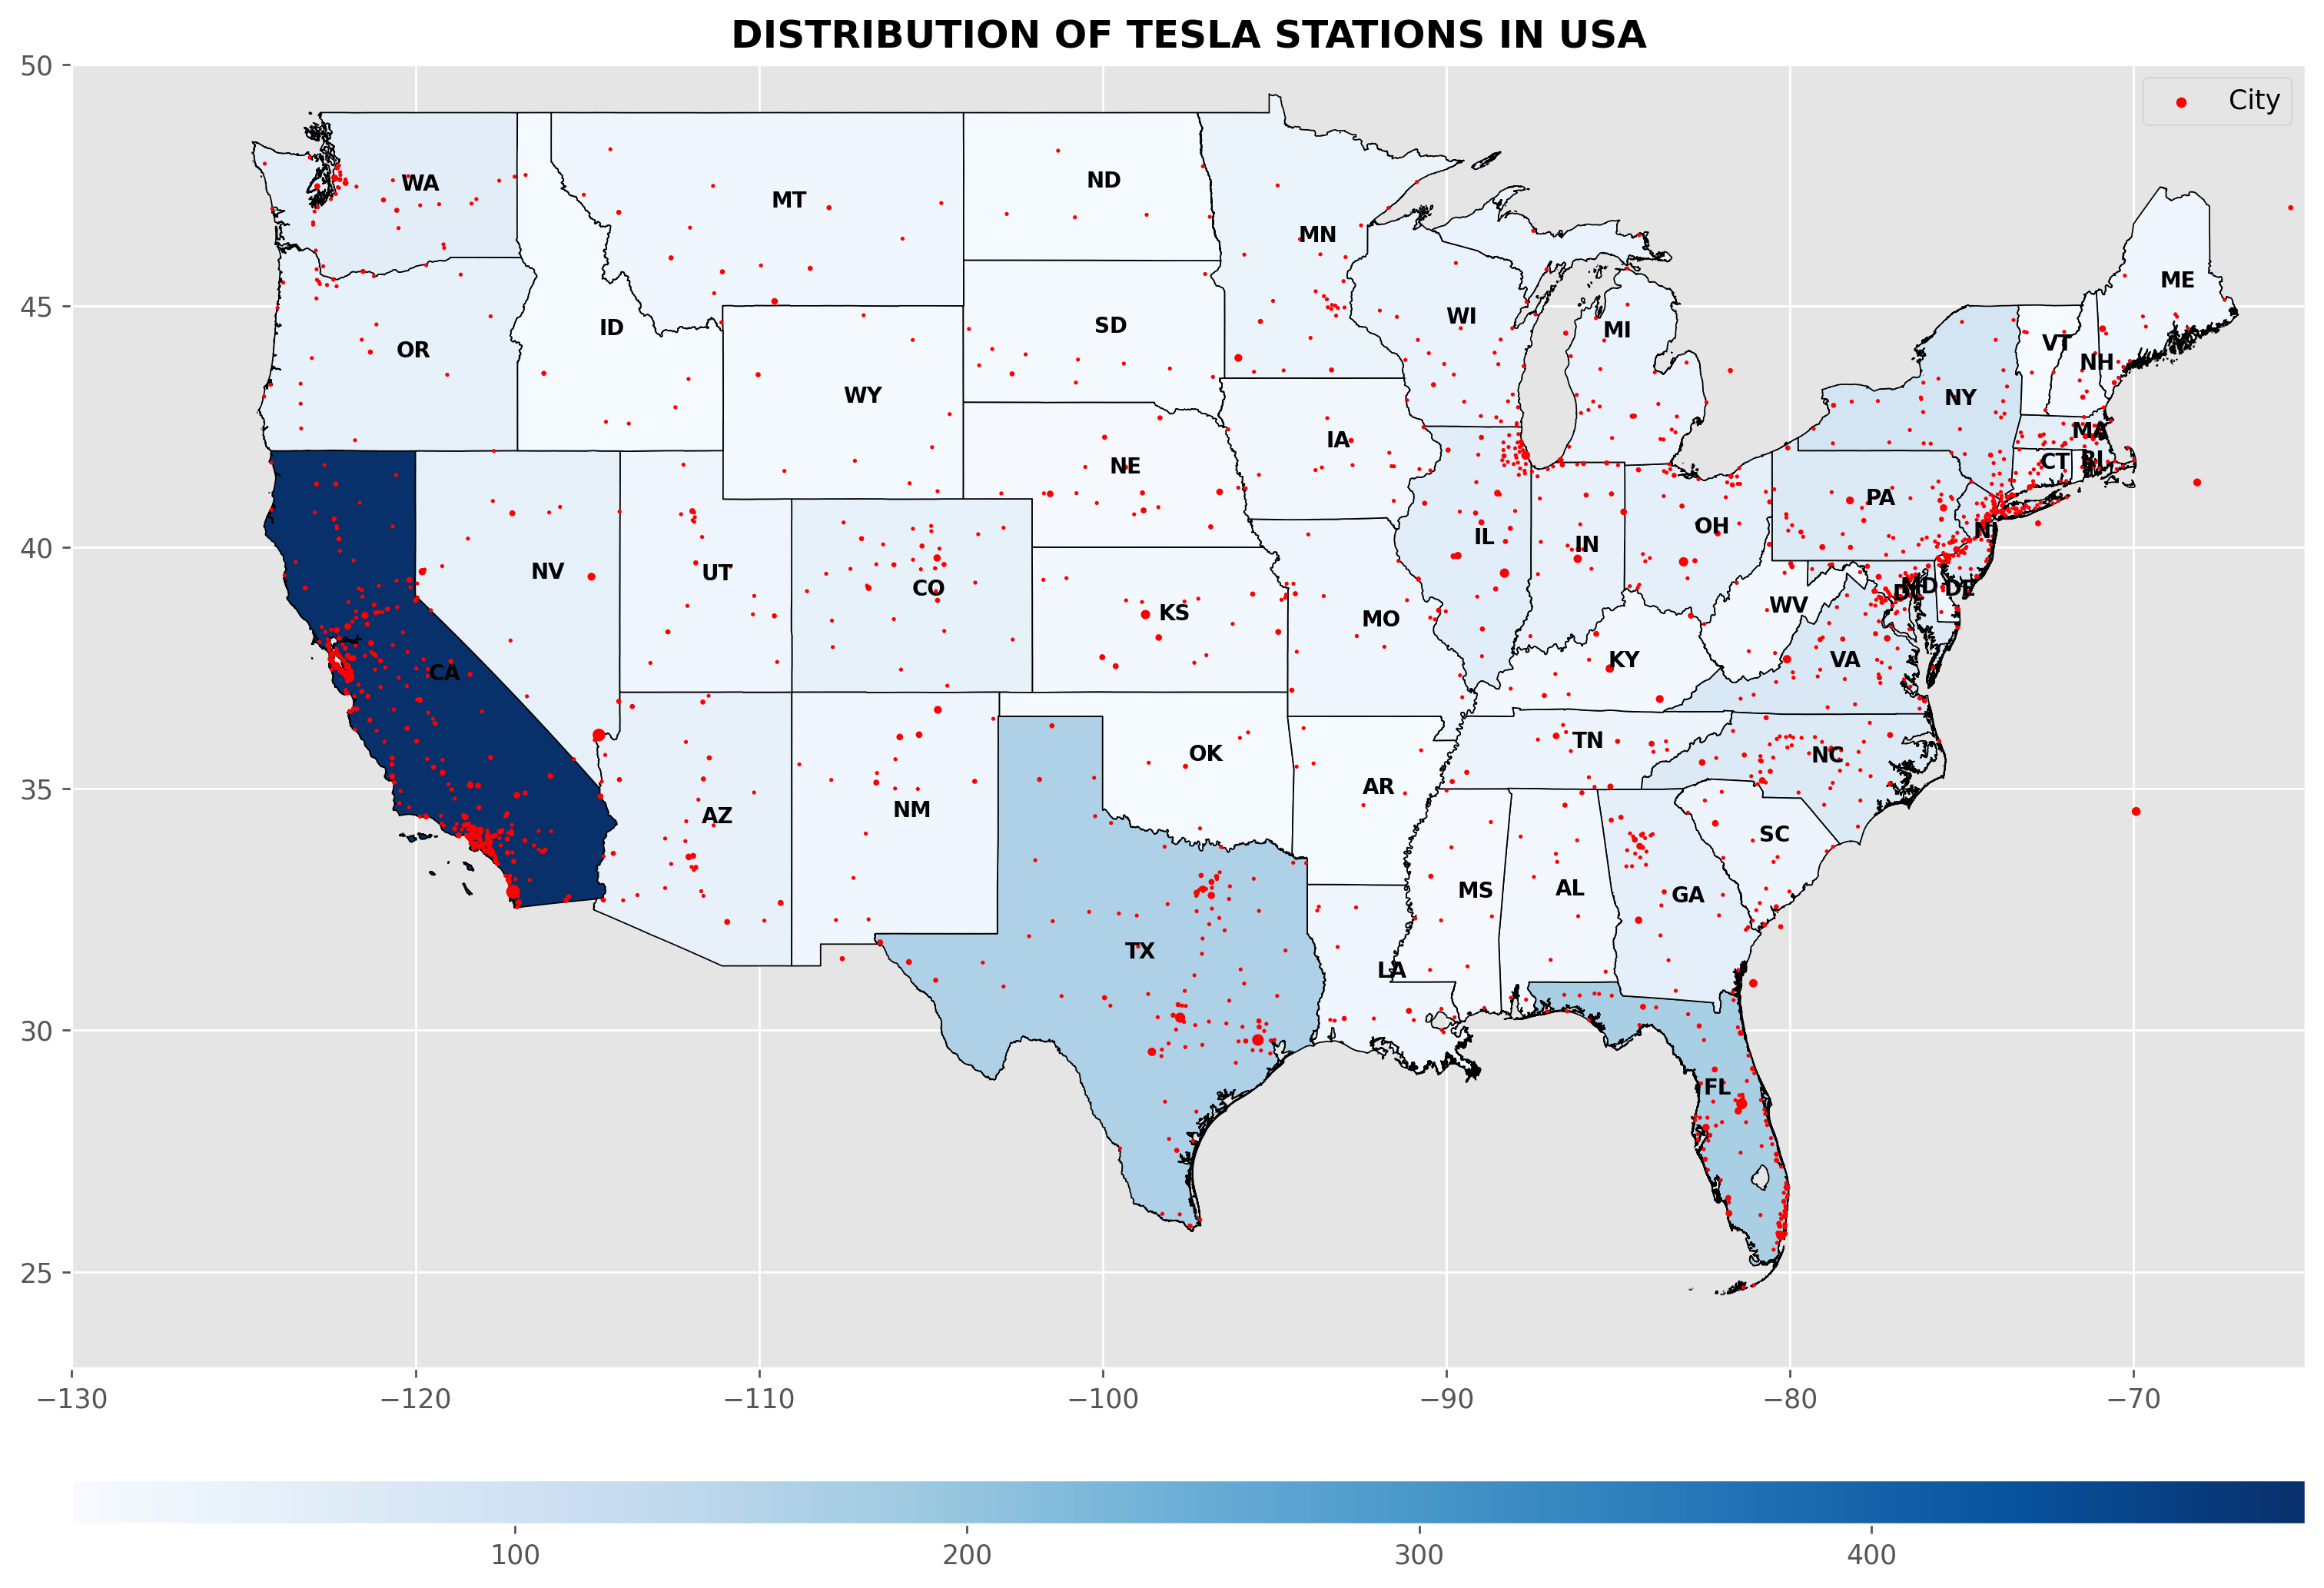

CPU times: total: 11 s
Wall time: 12.1 s


In [12]:
%%time

fig,ax=plt.subplots(figsize=(15,15),dpi=250)
usa_states_grouped.plot(ax=ax,column='State',cmap='Blues',ec='black',legend=True,legend_kwds={'orientation':'horizontal','aspect':50,'pad':0.05})
ax.scatter(usa_cities_grouped['City Long'],usa_cities_grouped['City Lat'],s=usa_cities_grouped['GPS'],color='Red',label='City')
plt.title('DISTRIBUTION OF TESLA STATIONS IN USA',fontweight='bold')
for i in range(len(usa_states_grouped)):
    if usa_states_grouped['index'].iloc[i] not in ['HI','AK','PR']:
        plt.text(usa_states_grouped['State Long'].iloc[i],usa_states_grouped['State Lat'].iloc[i],usa_states_grouped['index'].iloc[i],fontweight='bold',size=8)
plt.xlim(-130,-65)
plt.ylim(23,50)
plt.legend()
plt.show()

##### China 

In [13]:
china_cities_grouped=df.query('Country=="China"').groupby(['City','City Long','City Lat'])['GPS'].count().reset_index()
china_cities_grouped['Percent']=china_cities_grouped['GPS']/china_cities_grouped['GPS'].sum()*100

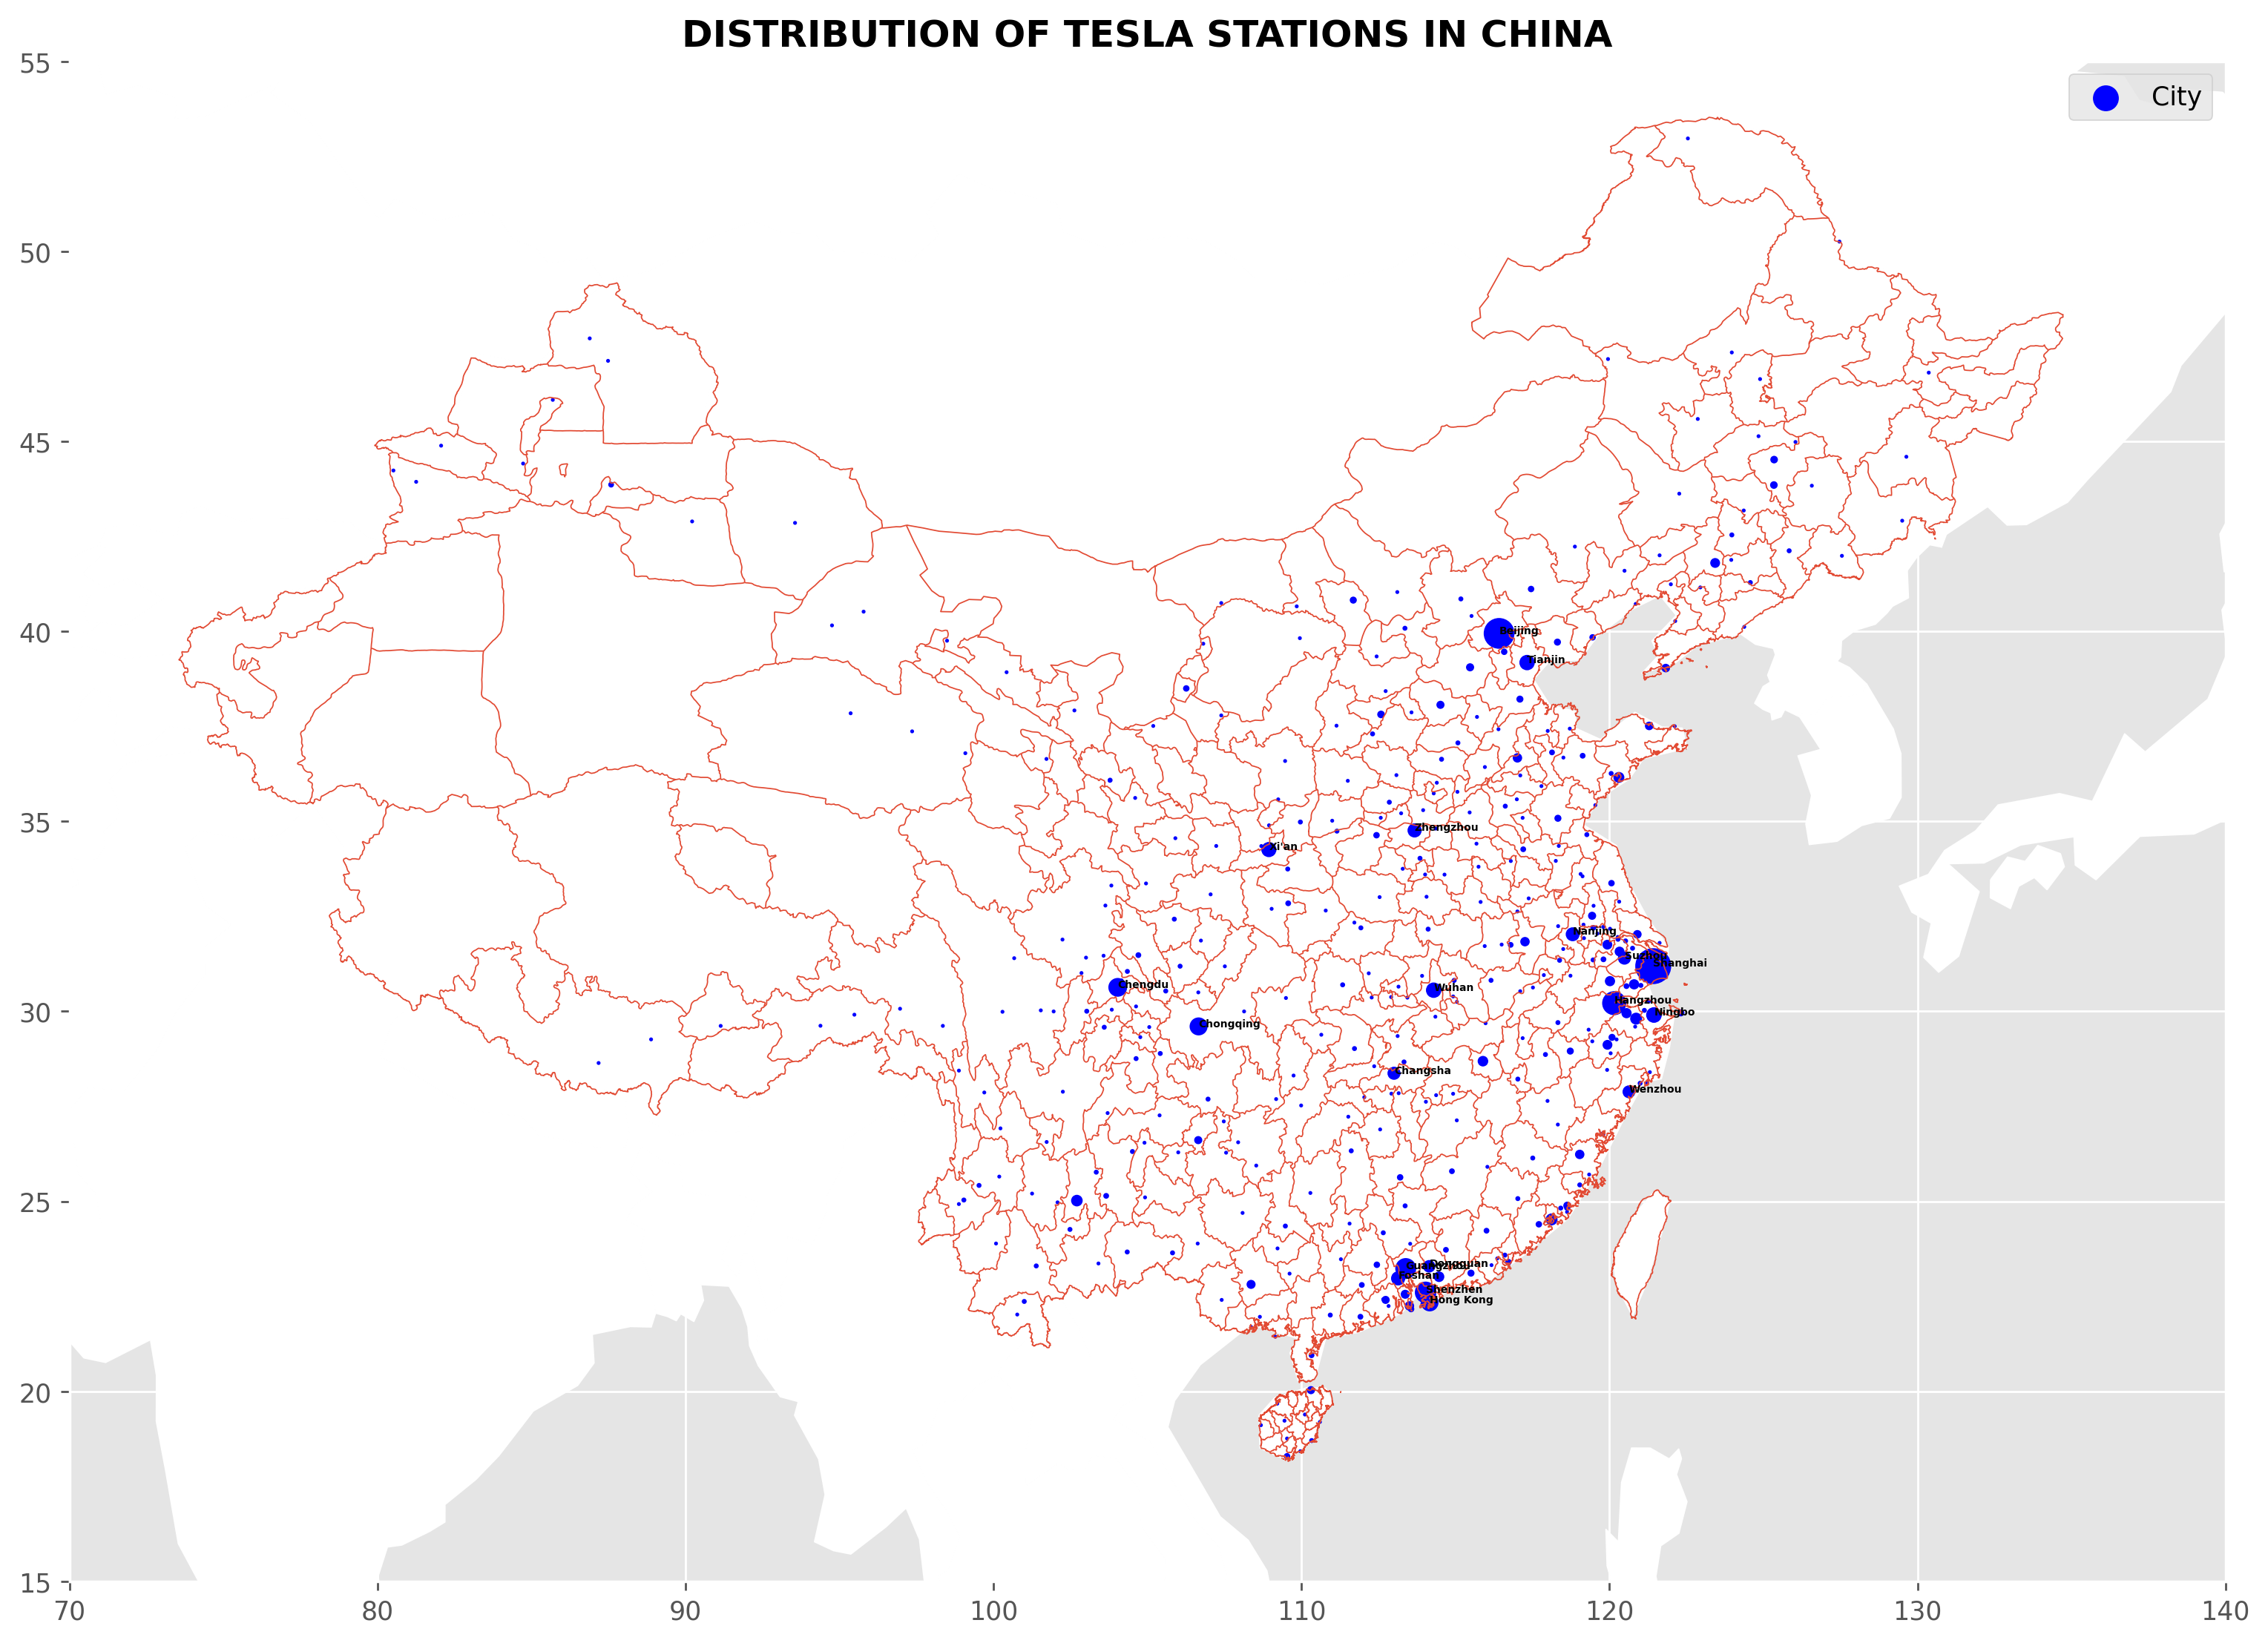

In [14]:
fig,ax=plt.subplots(figsize=(15,15),dpi=250)
world.plot(ax=ax,color='white',ec='white')
china.plot(ax=ax,linewidths=.5)
ax.scatter(china_cities_grouped['City Long'],china_cities_grouped['City Lat'],s=china_cities_grouped['GPS'],color='Blue',label='City')
plt.title('DISTRIBUTION OF TESLA STATIONS IN CHINA',fontweight='bold')
for i in range(len(china_cities_grouped)):
    if china_cities_grouped['Percent'].iloc[i]>1:
        plt.text(china_cities_grouped['City Long'].iloc[i],china_cities_grouped['City Lat'].iloc[i],china_cities_grouped['City'].iloc[i],fontweight='bold',size=4)
plt.xlim(70,140)
plt.ylim(15,55)
plt.legend()
plt.show()

In [15]:
df['Open Date']=pd.to_datetime(df['Open Date'])

In [16]:
countries=['USA','Canada','China','Germany','United Kingdom']

data=pd.DataFrame()
for country in countries:
    f=df[df['Country']==country]
    g=f.groupby(f['Open Date'].dt.to_period('Y'))['GPS'].count().reset_index()
    g['Country']=country
    g=g.sort_values(['Country','Open Date'])
    data=pd.concat([data,g])

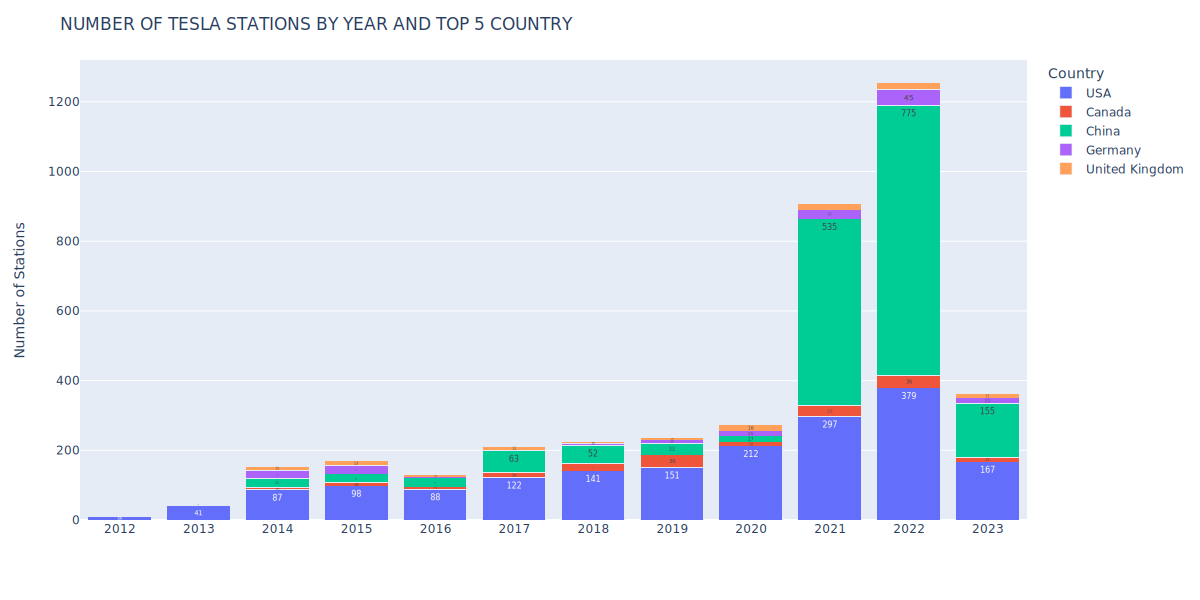

In [17]:
fig=px.bar(data,x=data['Open Date'].astype(str),y='GPS',color='Country',barmode='stack',text='GPS')
fig.update_layout(title=dict(text='NUMBER OF TESLA STATIONS BY YEAR AND TOP 5 COUNTRY',font_family='Arial Black'),height=600,width=1200)
fig.update_traces(textposition='inside', textfont_size=8)
fig.update_yaxes(title='Number of Stations')
fig.update_xaxes(title=None)
fig.show('svg')